## Understanding Image Segmentation using UNet & Model intepretability using Pytorch Captum 🖼

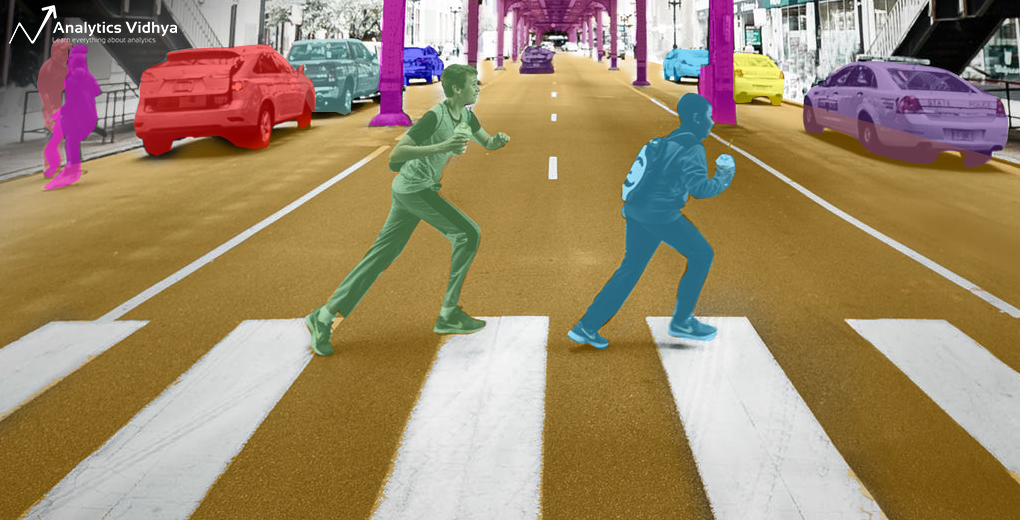

### 🎯 Goals & Objectives

There are several applications that come in the intersection of Computer vision and Deep learning, one such popular application is - **Semantic Segmentation in Images**. In this project idea, I will be working on an image dataset particularly containing Cars.

This dataset is great for training and testing models for image segmenatation with applications in autonomous driving and also driver assist.The dataset has diverse set of images when it comes to pose variation/background clutter/noise.The problems will be approached by means of employing **image segmenation models like UNet and using Convolutional Neural Network(CNN)**

In this portfolio idea some of the objectives that can be acheived through this data are -

   - Can the model be trained to detect and isolate/segment objects in the frame
   - Intepreting the Black Box Segmentation model using Pytorch's Captum tool
   
For this project the data will be sourced from a Kaggle dataset repository named - [Cityscapes Image Pairs- Semantic Segmentation for Improving Automated Driving.](https://www.kaggle.com/dansbecker/cityscapes-image-pairs)

This dataset has **2975 training images** files and **500 validation image** files. Each **image** file is **256x512 pixels**, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

🔎 <u><b>Problem to be addressed</u></b>-

For the given dataset of Cars in traffic, using UNet we need to create image segmemtation of the original image, the segmented image gives us a sense of where the objects are in the image. This has particular application autonomous driving to detect neighbouring cars/traffic/pedestrians and navigate accordingly.


### What is Semantic Segmentation?

When we work with any image tasks using CNNs, we mostly deal with Object detection or classifying an entire image as a certain class. When we talk about image segmentation, it involves **grouping together similar parts of the image** and **label** them of a **particular class.**

There are three steps involved in semantic segmentation - 

- **Classyfying** : Classifying a certain object in the image being analysed

- **Localizing** : Finding the object and **drawing a bounding box** around it

- **Segmentation** : Grouping the pixels in a localized part of the image and creating a segmentation mask, the mask defines each pixel to a particular class


Essentially, the task of segmentation can be referred to as a pixel level image classification, thereby separating it from rest of the image by means of using a segmentation mask.

Images speak more than words and the same is understood clearly in the image below.

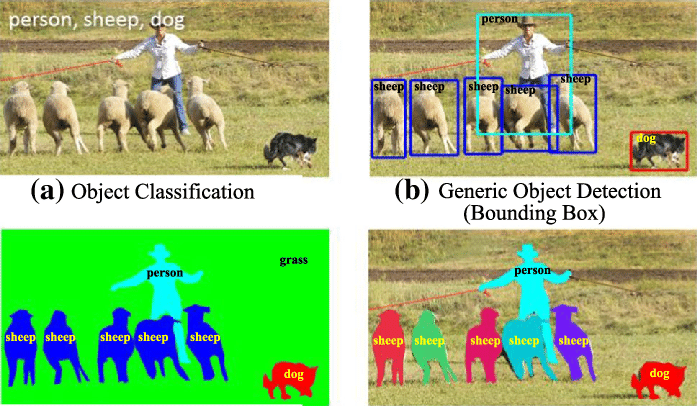

Image Credit: [research gate](https://www.researchgate.net/figure/Recognition-problems-related-to-generic-object-detection-a-image-level-object_fig1_336934637)

The goal of the task is to take an image and generate an output such that segmentation feature map contains pixel values (0 to 255) of the input image transformed into a class label of value (0, 1, 2, ... n).

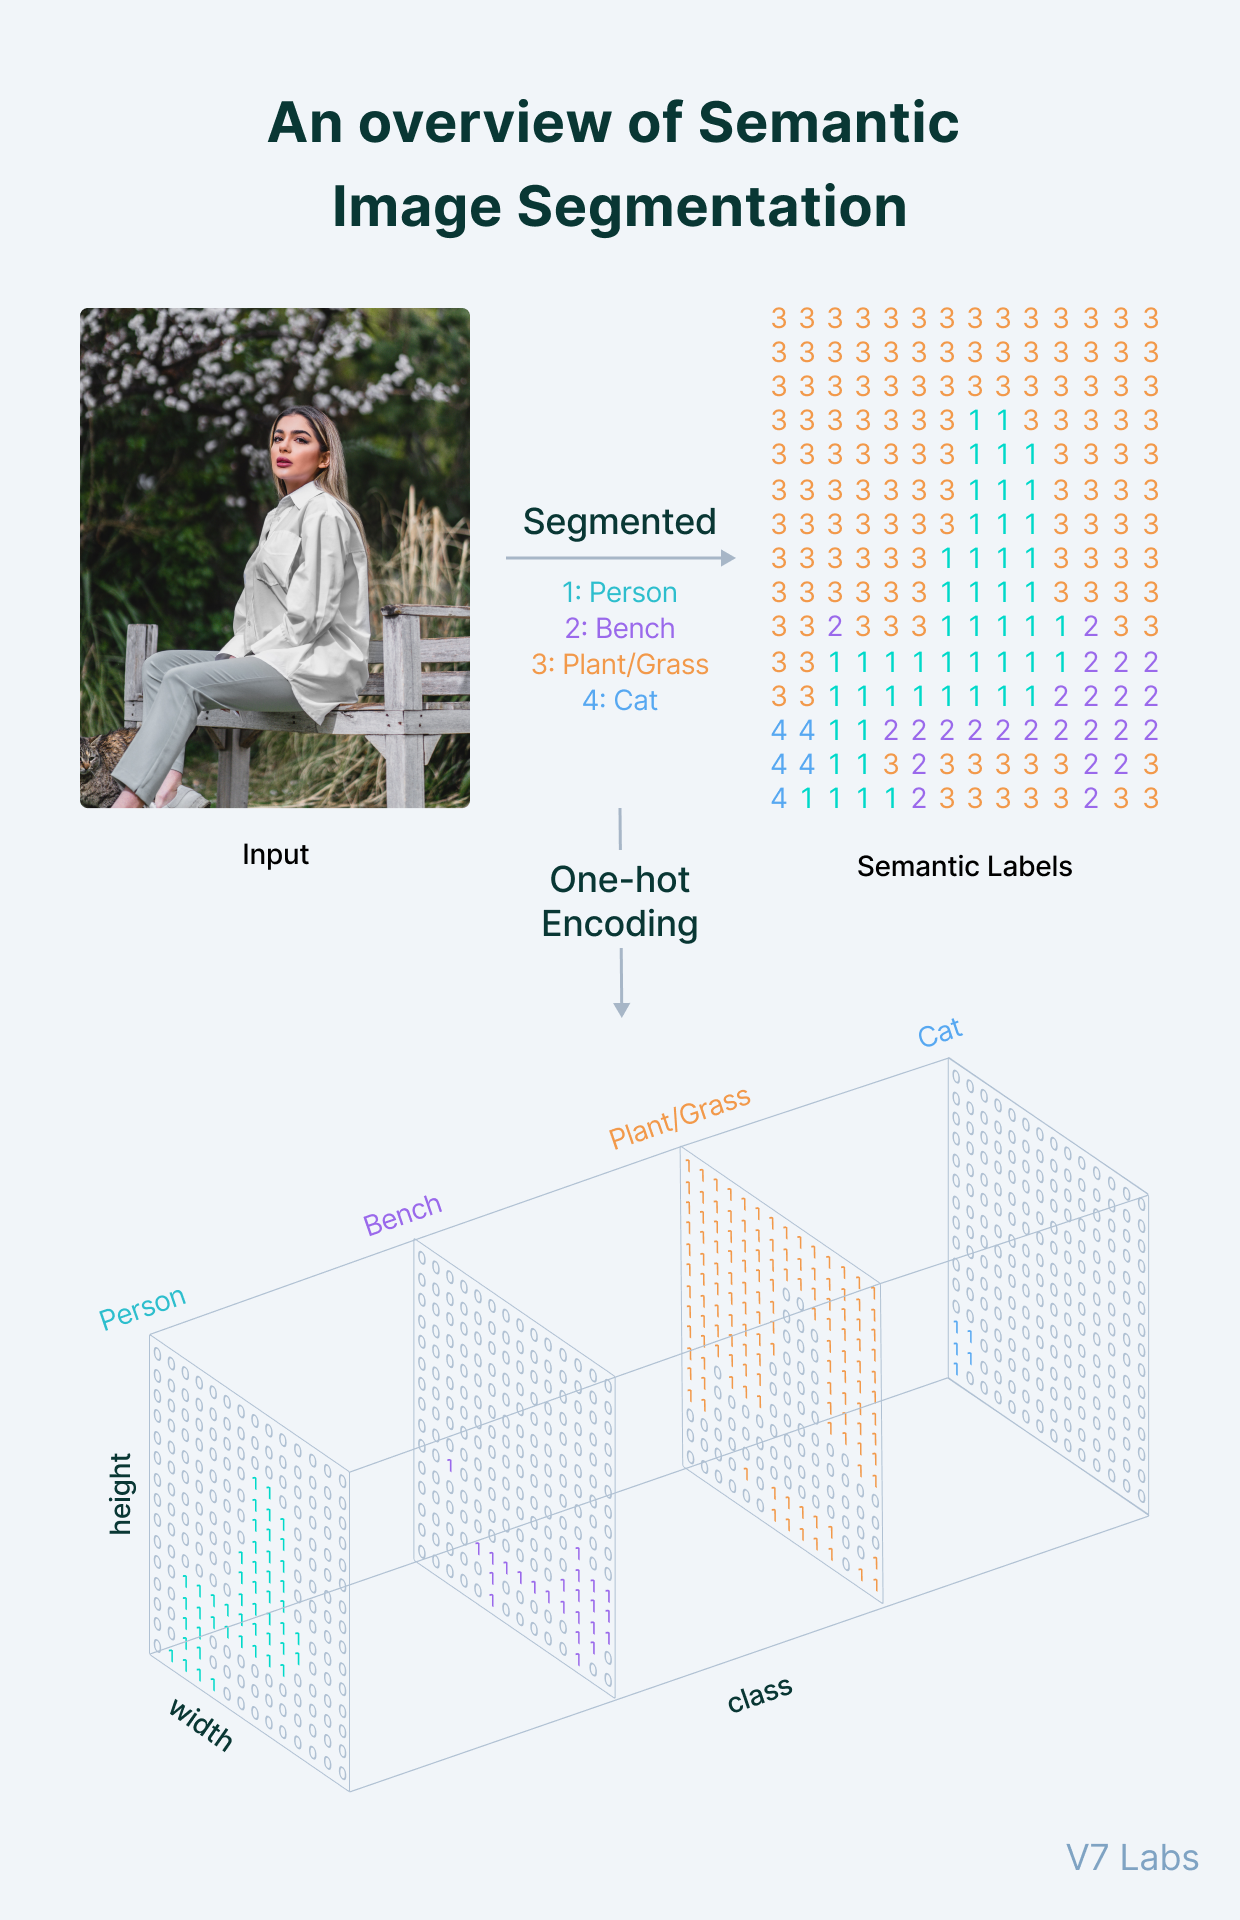


Image credit: V7 Labs

### What Deep learning Methods to use for Semantic Segmentation?

Convolutional Neural Networks (CNN) performs well on most computer vision tasks and its no surprise that it can work well with segmentation as well. But in order to deal with segmentation we need to use the **CNN architecture** but **with** some **modifications**, perhaps by adding extra layers and features or even changing the architechtural design altogether. 

In most cases, CNN has a fully connected layer at the end in order to make class label predictions.

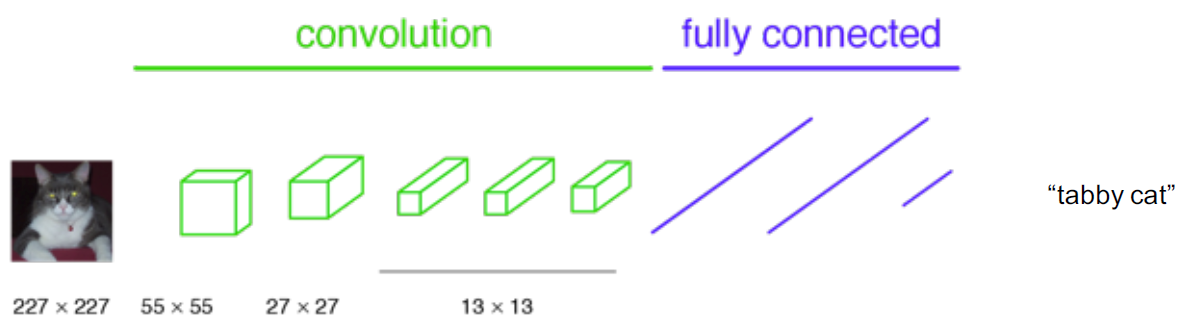

Image credit: V7 Labs

But - 

When it comes to semantic segmentation, we dont require a fully connected layer at the end because our end goal is **NOT** to predict class label of the image but to **mask individual objects as distinct classes in the image!**

**Another issue with Convolution** is the size of the image keeps reducing as it passes through the network because of MaxPool layers.

In order to segment the objects in the image, we need to **UpSample** it using an interpolation technique, which can be done using **Up-Convolution**. 

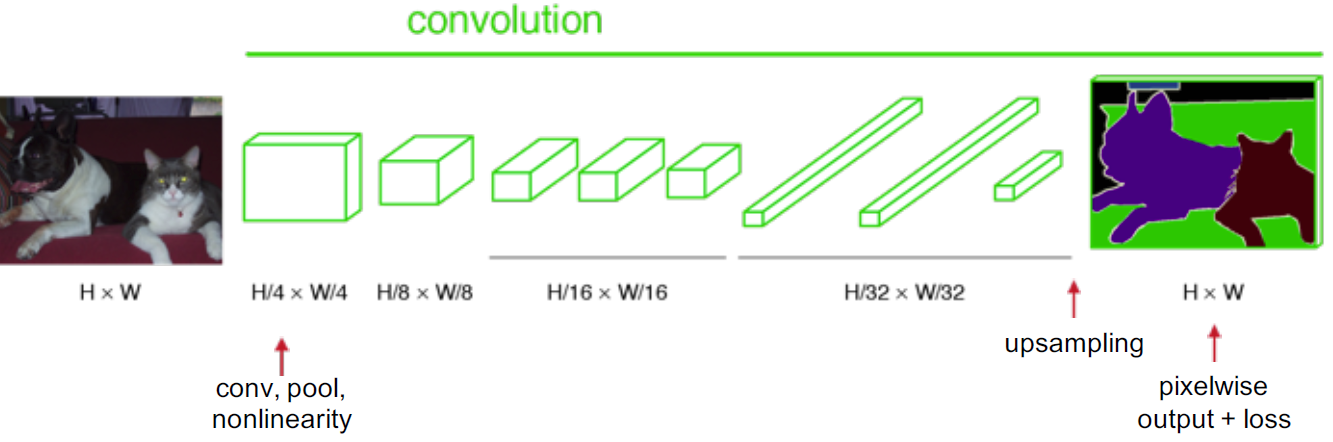


In terms of terminology, the convolution network that is used to **extract features** is called an **encoder**, meanwhile the convolution network that is used for **upsampling** is called **decoder**.
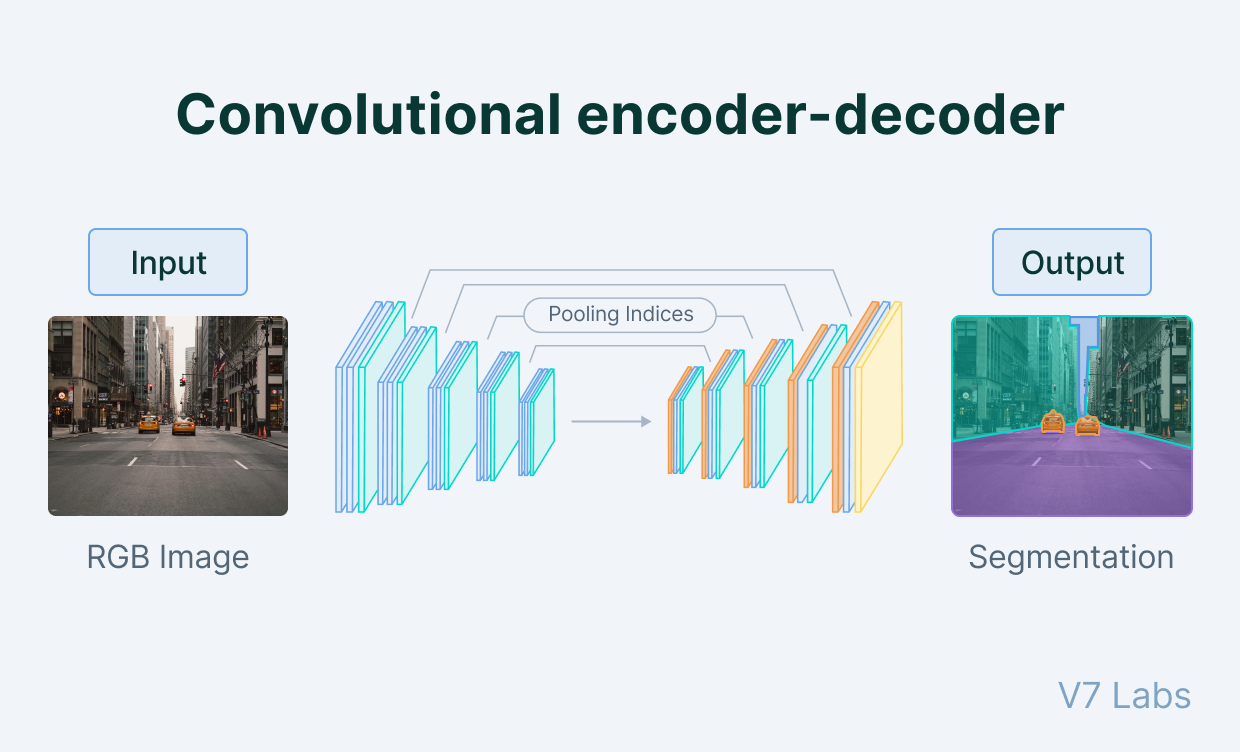




So, we feed in the image and this "encoder-decoder" will do the segmentation cleanly right? Well, not really. The issue being the output yielded by the decoder, since much of the information is lost in the final convolutional layer, it becomes difficult for the network to do the up-sampling given the sparse information it gets. Although there are architectures like FCN-16 and FCN-8 that handle this above problem, I am going to focus on how U-Net architecture handles this loss of information and up-samples efficiently.

### U-Net Architecture for Image Segmentation

The U-Net architecture is similar to fully convolutional network but with some modifications. It was introduced by Olaf Ronnenberger et al. in 2015 in the paper titled -  [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597), which was primarily to find tumors in lungs and in the brain.

![image](https://user-images.githubusercontent.com/13203059/146464403-b08e5fea-cee2-4d03-9aa1-f4101e750d29.png)


The difference between the fully convolutional network and U-Net is that the former uses the final extracted features to up sample while the later uses **Skip-connections to concatenate the feature maps from the contraction path(encoder) to expansion path(decoder)**, thus giving the network more localization information about the image.


As we move forward I will be implementing this above architecture from scratch using PyTorch to understand how it works and most importantly, look into this **black-box** of an architecture using **Interpretability** library called **Captum by PyTorch**.

## 1. Setup

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution

from tqdm import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
!nvidia-smi

Thu Dec 16 11:07:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:82:00.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      2MiB / 12198MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
data_dir = os.path.join('/home/zutshi.k/image-segmentation-dataset')
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


## 2. Analyze data

/home/zutshi.k/image-segmentation-dataset/train/919.jpg


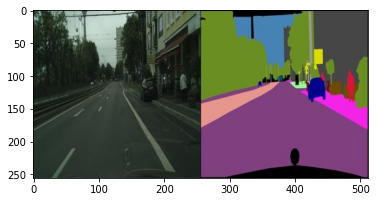

In [5]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [6]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 238 0 255


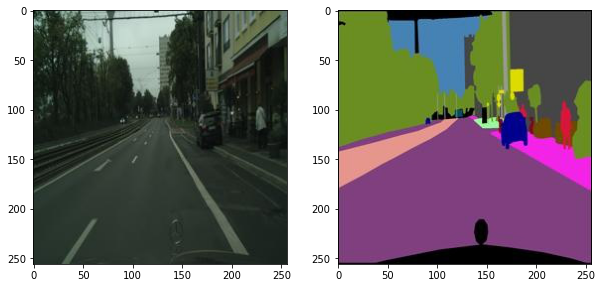

In [7]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

## 3. Define Labels

In [8]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[ 62 149 117]
 [188 134 190]
 [233 121 192]
 [247 244  82]
 [ 45  44 202]]


In [9]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [10]:
label_model.predict(color_array[:5, :])

array([8, 6, 6, 9, 3], dtype=int32)

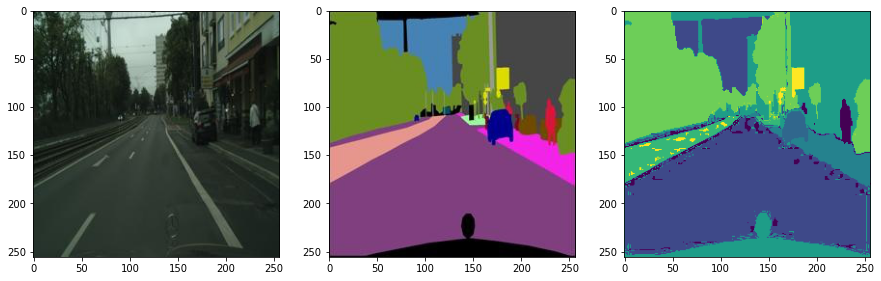

In [11]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [12]:
label_class

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 7, 7, ..., 5, 5, 5],
       ...,
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5]], dtype=int32)

## 4. Define Dataset

In [13]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [14]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [15]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


## 5. Define Model

In [16]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [17]:
model = UNet(num_classes=num_classes)

In [18]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [19]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


## 6. Train the model

In [20]:
batch_size = 16

epochs = 40
lr = 0.01

In [21]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [22]:
model = UNet(num_classes=num_classes).to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [24]:
step_losses = []
epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    train_accuracy=0.0
    train_loss=0.0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))
    print("epoch:", epoch, "epoch loss: ", epoch_loss)
print("___________________________________________________________________")

epoch: 0 epoch loss:  206.75419104099274


epoch: 1 epoch loss:  160.32060211896896


epoch: 2 epoch loss:  143.6513895392418


epoch: 3 epoch loss:  129.67393743991852


epoch: 4 epoch loss:  119.1960257589817


epoch: 5 epoch loss:  111.87481850385666


epoch: 6 epoch loss:  107.71983110904694


epoch: 7 epoch loss:  102.13208058476448


epoch: 8 epoch loss:  98.36262705922127


epoch: 9 epoch loss:  95.26497992873192


epoch: 10 epoch loss:  91.99848839640617


epoch: 11 epoch loss:  89.15633624792099


epoch: 12 epoch loss:  85.8059952557087


epoch: 13 epoch loss:  83.8067224919796


epoch: 14 epoch loss:  80.40130186080933


epoch: 15 epoch loss:  79.11479523777962


epoch: 16 epoch loss:  75.45031034946442


epoch: 17 epoch loss:  77.79748067259789


epoch: 18 epoch loss:  71.84691652655602


epoch: 19 epoch loss:  67.91375190019608


epoch: 20 epoch loss:  64.70109766721725


epoch: 21 epoch loss:  62.310420364141464


epoch: 22 epoch loss:  59.6971181333065


epoch: 23 epoch loss:  57.26165147125721


epoch: 24 epoch loss:  54.71562094986439


epoch: 25 epoch loss:  52.79186429083347


epoch: 26 epoch loss:  50.57860767841339


epoch: 27 epoch loss:  48.729488506913185


epoch: 28 epoch loss:  47.681666508316994


epoch: 29 epoch loss:  46.77642601728439


epoch: 30 epoch loss:  46.05442789196968


epoch: 31 epoch loss:  46.20105856657028


epoch: 32 epoch loss:  45.76551789045334


epoch: 33 epoch loss:  43.790047481656075


epoch: 34 epoch loss:  42.934634283185005


epoch: 35 epoch loss:  42.80051663517952


epoch: 36 epoch loss:  41.694410130381584


epoch: 37 epoch loss:  40.60384428501129


epoch: 38 epoch loss:  39.76775401830673


epoch: 39 epoch loss:  39.25782385468483
___________________________________________________________________


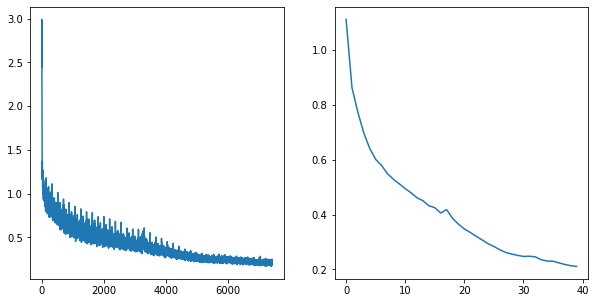

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# axes[0].plot.xlabel('Step loss')
# axes[0].plot.ylabel('Loss')
# axes[0].plot.title('Step Loss')
axes[0].plot(step_losses)


# axes[1].plot.xlabel('Epoch loss')
# axes[1].plot.ylabel('Loss')
# axes[1].plot.title('Epoch Loss')
axes[1].plot(epoch_losses)

In [29]:
model_name = "U-Net-ood-40Epoch.pth"
torch.save(model.state_dict(), model_name)

## 7. Check model predictions

In [30]:
model_path = "/home/zutshi.k/U-Net-ood-40Epoch.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [31]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [32]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [33]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

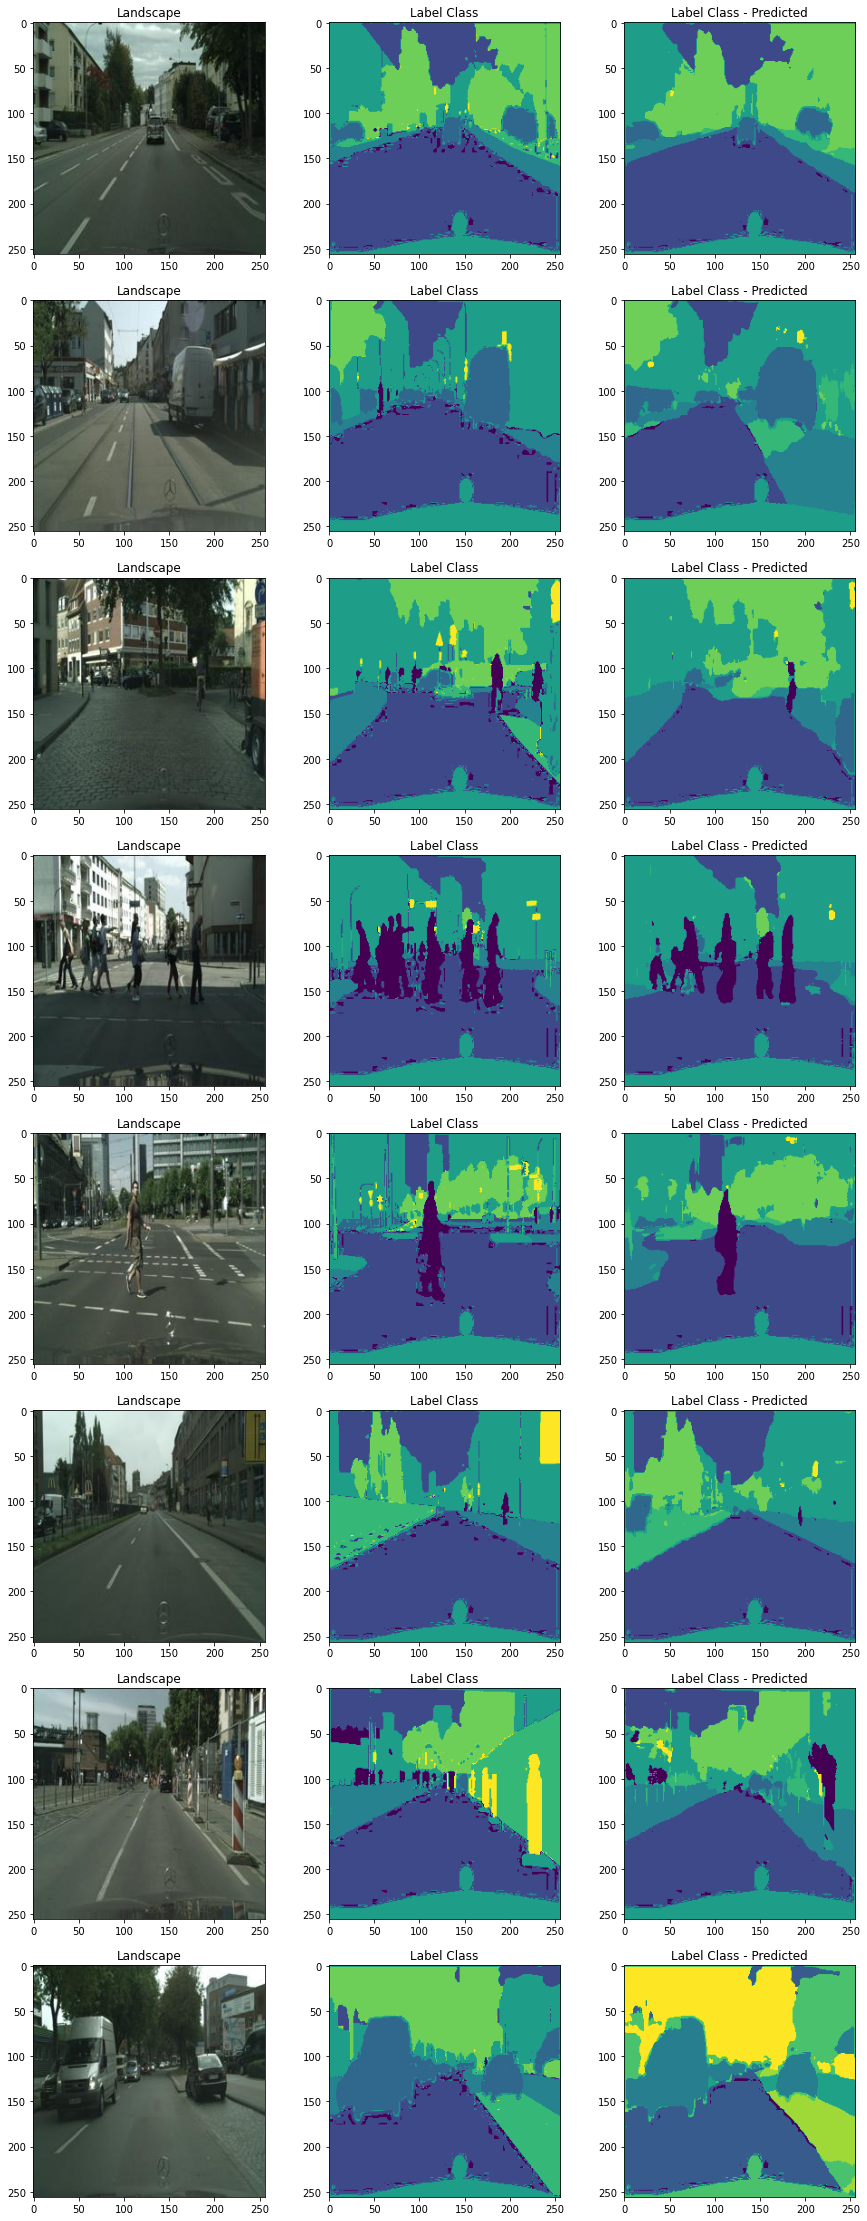

In [34]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

### Model Intepretability Using Captum 🔎


Reference 📑 - 

https://captum.ai/tutorials/Segmentation_Interpret

Captum is an open source, extensible library for model interpretability built on PyTorch. There a various ways of explaining model output and layer activity(Attribution), one of them is Feature Attribution.
Feature Attribution lets us ask which pixels in the input image drove the model to label them to a certain group and hence resulting in Image Segmentation. But feature attribution just covers inputs and outputs. What if we need to inspect what happens in between layers of the model?

In that case, we go for Layer Attribution, it explains the activity of hidden layers in terms of individual input features. Layer attribution helps us answer the following - 

- Which neurons in this layer were most active given this input?

- Which neurons in this layer were most important to how the input influenced a particular output neuron?

- How is the activation map output by this convolutional layer correlated to my input image?

Following the captum documentation, helped me get started with using the library in my code. Now, in order to get the outputs from layers of the network, I kept checkpoints after each contracting and expanding layer.

In [35]:
# This method allows us to visualize a particular segmentation output, by setting
# each pixels color according to the given segmentation class provided in the 
# image (segmentation output).
def decode_segmap(image, nc=21):  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [36]:
# Input preprocessing transformation
preprocessing = transforms.Compose([transforms.Resize(640), 
                                    transforms.ToTensor()])
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

/home/zutshi.k/image-segmentation-dataset/val/272.jpg


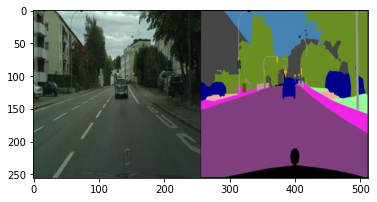

In [37]:
sample_image_val_fp = os.path.join(val_dir, val_fns[0])
sample_image_val = Image.open(sample_image_val_fp).convert("RGB")
plt.imshow(sample_image_val)
print(sample_image_val_fp)

(256, 512, 3)
0 255 0 255


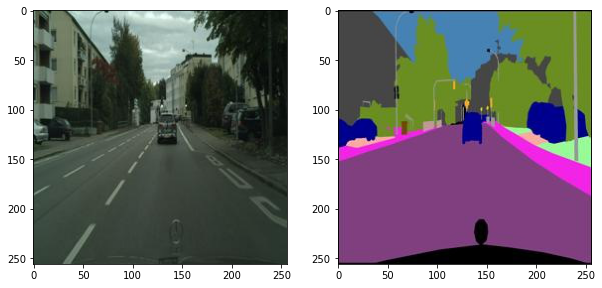

In [38]:
sample_image_val = np.array(sample_image_val)
print(sample_image_val.shape)
cityscape, label = split_image(sample_image_val)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

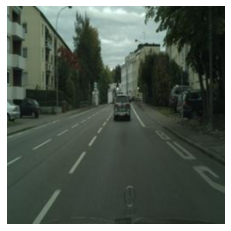

In [39]:
preproc_img = preprocessing(cityscape)
plt.imshow(preproc_img.permute(1,2,0)); plt.axis('off'); plt.show()

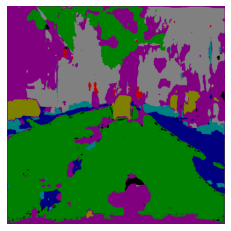

In [40]:
# Normalize image and compute segmentation output
normalized_inp = normalize(preproc_img).unsqueeze(0).to(device)
normalized_inp.requires_grad = True
out = model_(normalized_inp)

# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)

# Visualize segmentation output using utility method.
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
plt.imshow(rgb); plt.axis('off'); plt.show()

In [41]:
"""
This wrapper computes the segmentation model output and sums the pixel scores for
all pixels predicted as each class, returning a tensor with a single value for
each class. This makes it easier to attribute with respect to a single output
scalar, as opposed to an individual pixel output attribution.
"""
def agg_segmentation_wrapper(inp):
    model_out = model_(inp)
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3))


# Alternate wrapper, simply summing each output channel
# def wrapper(inp):
#   return fcn(inp)['out'].sum(dim=(2,3))

#### Check what is happening at Contracting layer 4

In [43]:
lgc = LayerGradCam(agg_segmentation_wrapper, model_.middle[0])

In [44]:
gc_attr = lgc.attribute(normalized_inp, target=7)

In [45]:
la = LayerActivation(agg_segmentation_wrapper, model_.middle[0])
activation = la.attribute(normalized_inp)
print("Input Shape:", normalized_inp.shape)
print("Layer Activation Shape:", activation.shape)
print("Layer GradCAM Shape:", gc_attr.shape)

Input Shape: torch.Size([1, 3, 640, 640])
Layer Activation Shape: torch.Size([1, 1024, 40, 40])
Layer GradCAM Shape: torch.Size([1, 1, 40, 40])


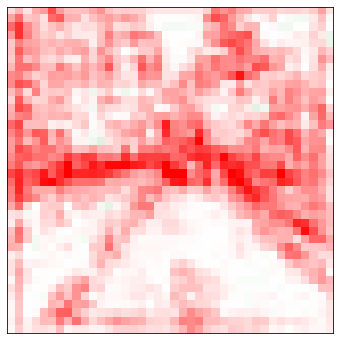

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [46]:
viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),sign="all")

In [47]:
upsampled_gc_attr = LayerAttribution.interpolate(gc_attr,normalized_inp.shape[2:])
print("Upsampled Shape:",upsampled_gc_attr.shape)

Upsampled Shape: torch.Size([1, 1, 640, 640])


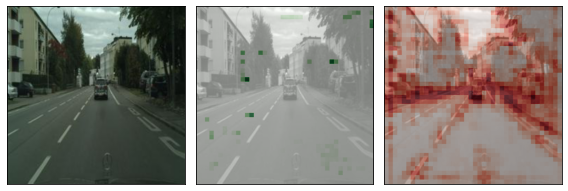

(<Figure size 576x432 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [48]:
viz.visualize_image_attr_multiple(upsampled_gc_attr[0].cpu().permute(1,2,0).detach().numpy(),original_image=preproc_img.permute(1,2,0).numpy(),signs=["all", "positive", "negative"],methods=["original_image", "blended_heat_map","blended_heat_map"])

#### Check what is happening at Expansive layer 4

In [53]:
lgc = LayerGradCam(agg_segmentation_wrapper, model_.expansive_42[0])

In [54]:
gc_attr = lgc.attribute(normalized_inp, target=7)

In [55]:
la = LayerActivation(agg_segmentation_wrapper, model_.expansive_42[0])
activation = la.attribute(normalized_inp)
print("Input Shape:", normalized_inp.shape)
print("Layer Activation Shape:", activation.shape)
print("Layer GradCAM Shape:", gc_attr.shape)

Input Shape: torch.Size([1, 3, 640, 640])
Layer Activation Shape: torch.Size([1, 64, 640, 640])
Layer GradCAM Shape: torch.Size([1, 1, 640, 640])


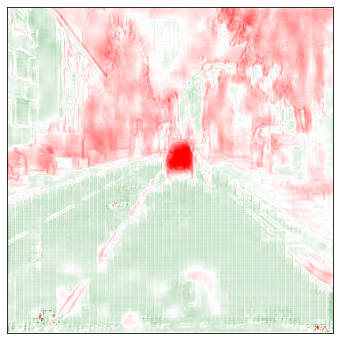

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [56]:
viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),sign="all")

#### Check what is happening at Output

In [57]:
lgc = LayerGradCam(agg_segmentation_wrapper, model_.output)

In [58]:
gc_attr = lgc.attribute(normalized_inp, target=7)

In [59]:
la = LayerActivation(agg_segmentation_wrapper, model_.output)
activation = la.attribute(normalized_inp)
print("Input Shape:", normalized_inp.shape)
print("Layer Activation Shape:", activation.shape)
print("Layer GradCAM Shape:", gc_attr.shape)

Input Shape: torch.Size([1, 3, 640, 640])
Layer Activation Shape: torch.Size([1, 10, 640, 640])
Layer GradCAM Shape: torch.Size([1, 1, 640, 640])


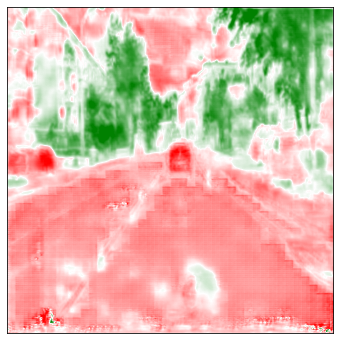

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [60]:
viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),sign="all")

### What were the results?

Now, the output of each layer helped understand what the Network Architecture section in the U-Net: Convolutional Networks for Biomedical Image Segmentation paper ment.

Below is how the input image looked as its passed through the 4 contracting (encoder) layers of UNet.

Colormap for heatmap visualization -  This defaults to "Reds" for negative sign, "Blues" for absolute value, "Greens" for positive sign, and a spectrum from red to green for all. In these images we can see how the different layers see different pixels as important to be labelled together with other similar labelled pixels, hence resulting in Image segmentation.

In [63]:
checkpoint_layers = [model_.contracting_11[0], model_.contracting_21[0], model_.contracting_31[0], model_.contracting_41[0], model_.middle[0], model_.expansive_11, model_.expansive_12[0], model_.expansive_21, model_.expansive_22[0], model_.expansive_31, model_.expansive_32[0], model_.expansive_41, model_.expansive_42[0], model_.output]

In [67]:
for layer in checkpoint_layers:
    print('Output of UNet at layer - ', layer)
    lgc = LayerGradCam(agg_segmentation_wrapper, layer)
    gc_attr = lgc.attribute(normalized_inp, target=7)
    la = LayerActivation(agg_segmentation_wrapper, layer)
    activation = la.attribute(normalized_inp)
    viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),sign="all")

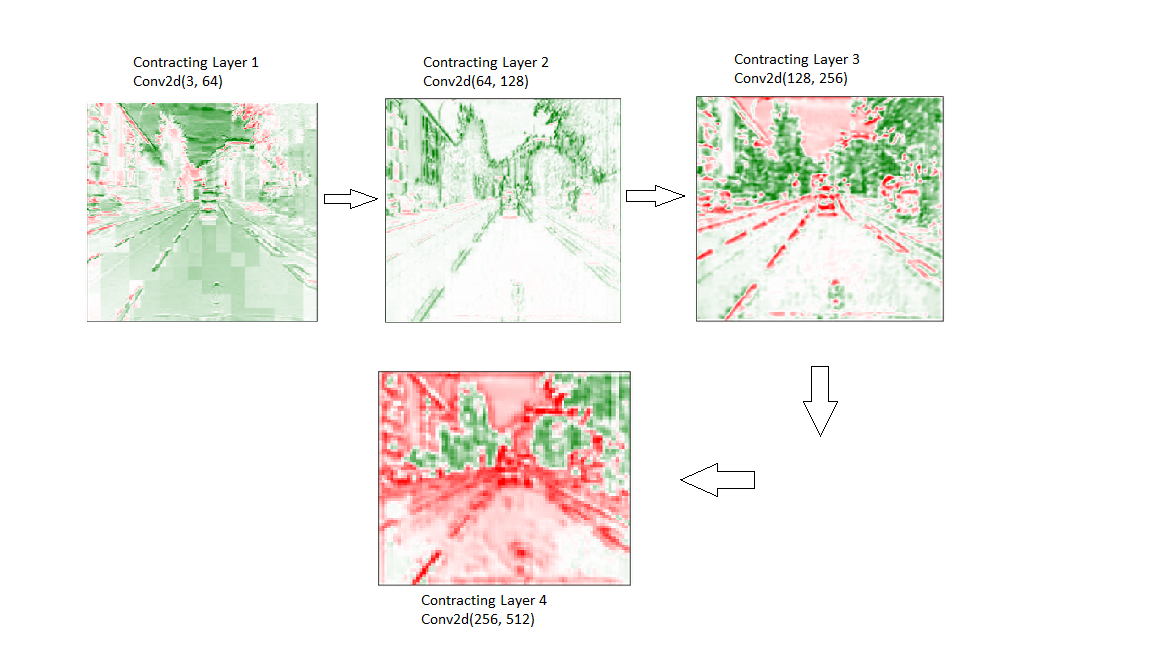

Now, the middle layer is where the concatenation happens.

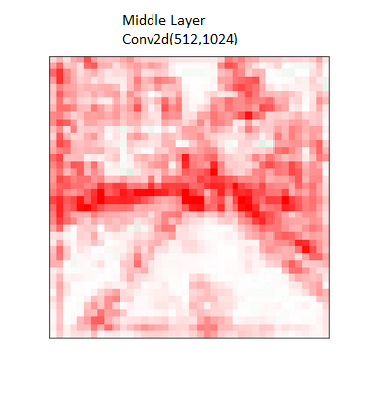

Looking at Expansive Layers 1 through 8 and finally the Output.

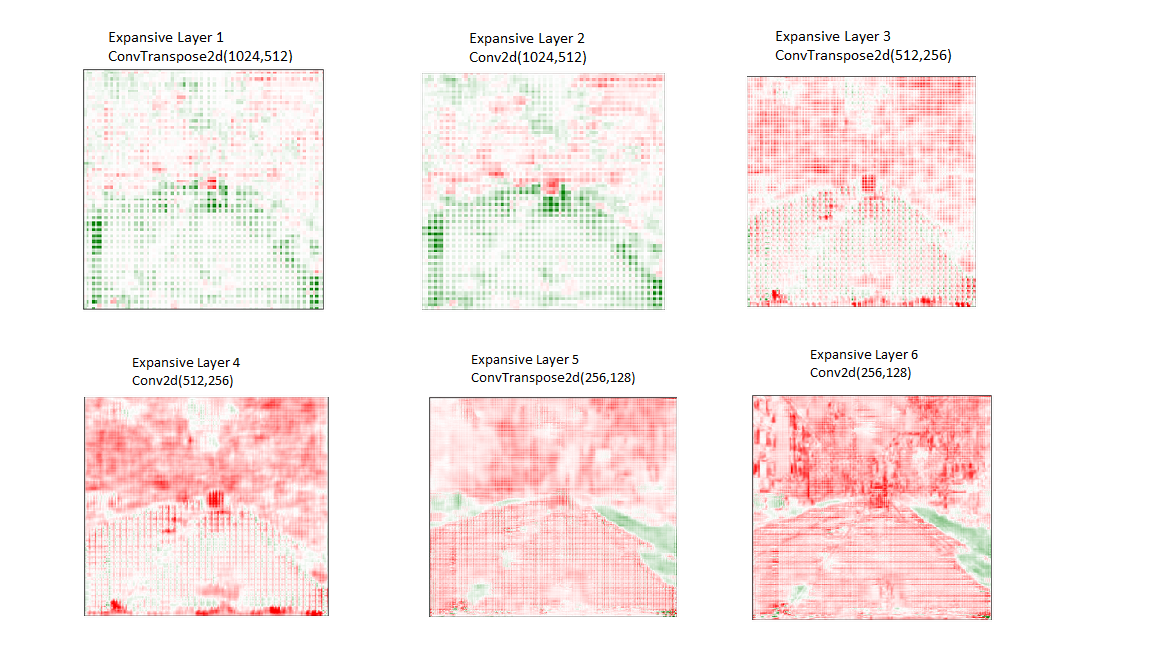

The ConvTranspose does the Up-Scaling.

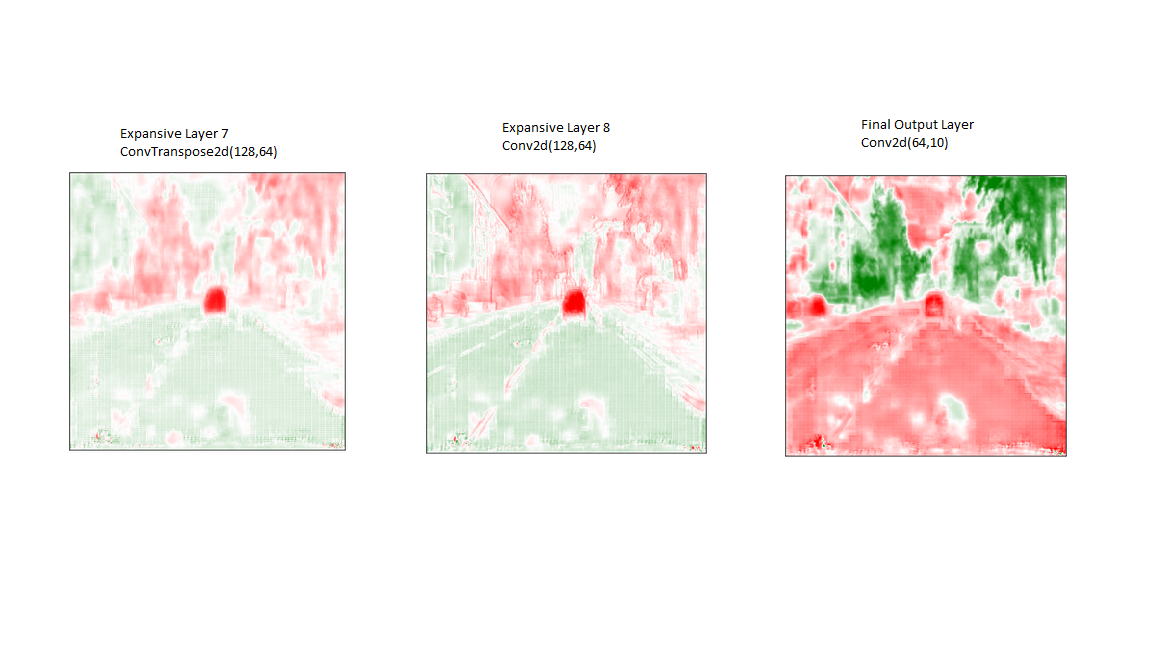

### Conclusion 📝

In this portfolio piece we looked at Image segmentation problem on City scape Image dataset of cars in Traffic from Kaggle. Using the UNet CNN model image segmentation of various objects in the image was done, the segmented image gave a sense of where the objects are in the image.

After looking at the Pytorch implemetation of UNet from scratch, the emphasis was on the model interpretation using Captum library(built on PyTorch) on feature attribution level and layer attribution level. Which helped in understanding how each pixel was perceived after each contracting and expansive layer in UNet and eventually led the model to label the group of pixels to be of the same object.

### References 📑

1. [U Net : Convolutional networks for Biomedical image segmentation by Olaf Ronneberger et al., ](https://arxiv.org/abs/1505.04597)
2. [Model Understanding with Captum - PyTorch](https://www.youtube.com/watch?v=Am2EF9CLu-g)
3. [Semantic Segmentation guide - V7 Labs](https://www.v7labs.com/blog/semantic-segmentation-guide)
4. https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
5. https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/
6. https://www.kaggle.com/gokulkarthik/image-segmentation-with-unet-pytorch
7. https://github.com/pytorch/captum/issues/343